Observation shape: (5, 5)
Action space: Box(-1.0, 1.0, (2,), float32)
Episode 1, Reward: 15.05
Episode 2, Reward: 3.70
Episode 3, Reward: 1.65
Episode 4, Reward: 0.80
Episode 5, Reward: 16.38
Episode 6, Reward: 13.46
Episode 7, Reward: 24.60
Episode 8, Reward: 22.94
Episode 9, Reward: 0.83
Episode 10, Reward: 33.52
Episode 11, Reward: 10.67
Episode 12, Reward: 10.79
Episode 13, Reward: 13.63
Episode 14, Reward: 18.01
Episode 15, Reward: 14.07
Episode 16, Reward: 13.04
Episode 17, Reward: 10.85
Episode 18, Reward: 35.64
Episode 19, Reward: 14.20
Episode 20, Reward: 26.61
Episode 21, Reward: 20.56
Episode 22, Reward: 160.58
Episode 23, Reward: 26.11
Episode 24, Reward: 27.22
Episode 25, Reward: 37.31
Episode 26, Reward: 12.09
Episode 27, Reward: 13.24
Episode 28, Reward: 39.32
Episode 29, Reward: 18.18
Episode 30, Reward: 18.49
Episode 31, Reward: 21.21
Episode 32, Reward: 30.56
Episode 33, Reward: 28.01
Episode 34, Reward: 13.65
Episode 35, Reward: 15.46
Episode 36, Reward: 14.06
Episod

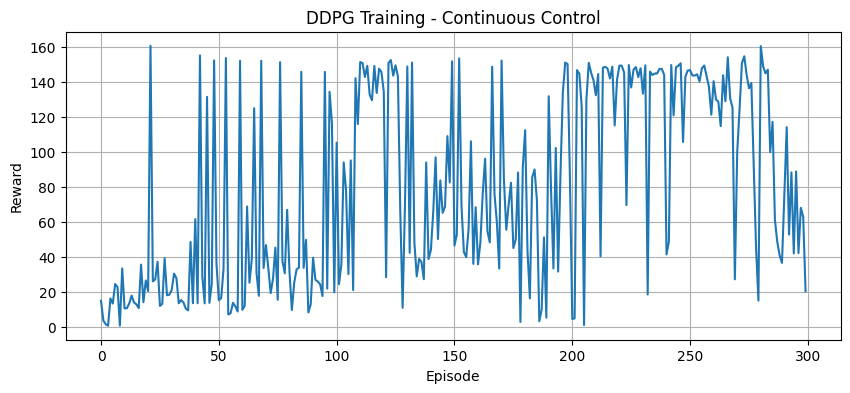

In [ ]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# Environment config (already modified to use ContinuousAction)
env = gym.make("highway-v0", render_mode="rgb_array", disable_env_checker=True)
config = {
    "observation": {"type": "Kinematics"},
    "action": {"type": "ContinuousAction"},
    "lanes_count": 2,
    "vehicles_count": 10,
    "duration": 40,
    "simulation_frequency": 15,
    "policy_frequency": 5,
}
env.unwrapped.configure(config)
obs, _ = env.reset()
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)

# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x * self.max_action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.cat([x, u], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class DDPG:
    def __init__(self, state_dim, action_dim, max_action, device):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.max_action = max_action
        self.device = device

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.flatten().reshape(1, -1)).to(self.device)
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise > 0:
            action = (action + noise * np.random.randn(*action.shape)).clip(-self.max_action, self.max_action)
        return action

    def train(self, batch_size=64, gamma=0.99, tau=0.005):
        if len(self.replay_buffer) < batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).reshape(-1, 1).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).reshape(-1, 1).to(self.device)

        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, next_action)
            target_Q = reward + (1 - done) * gamma * target_Q

        current_Q = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_obs, _ = env.reset()
state_dim = np.array(env.reset()[0]).flatten().shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

ddpg = DDPG(state_dim, action_dim, max_action, device)

num_episodes = 300
max_steps = 300
batch_size = 64
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for step in range(max_steps):
        action = ddpg.select_action(state.flatten())
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ddpg.replay_buffer.push(state.flatten(), action, reward, next_state.flatten(), float(done))
        state = next_state

        ddpg.train(batch_size)
        episode_reward += reward
        if done:
            break

    reward_history.append(episode_reward)
    print(f"Episode {episode+1}, Reward: {episode_reward:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG Training - Continuous Control")
plt.grid(True)
plt.show()
